In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

### Preprocessing

In [2]:
# import data from excel sheets

xls = pd.ExcelFile("covid_dataset.xlsx")
xls.sheet_names

['Confirmed cases', 'Deaths', 'Recovered']

In [3]:
# create dataframe for analysis

covid_cases_df = pd.read_excel(xls, 'Confirmed cases')
covid_deaths_df = pd.read_excel(xls, 'Deaths')
covid_recovered_df = pd.read_excel(xls, 'Recovered')
covid_cases_df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0


In [4]:
# convert dates to datetime format

covid_cases_df = covid_cases_df.drop(['SNo'], axis=1)
covid_cases_df['ObservationDate'] = pd.to_datetime(covid_cases_df['ObservationDate'], format="%d-%b-%y")

In [5]:
# group cases by country

by_country = covid_cases_df.groupby('Country/Region')

In [6]:
india_df = by_country.get_group('India').reset_index(drop=True)
india_df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed
0,2020-01-30,NaN,India,1/30/20 16:00,1
1,2020-01-31,NaN,India,1/31/2020 23:59,1
2,2020-02-01,NaN,India,1/31/2020 8:15,1
3,2020-02-02,NaN,India,2020-02-02T06:03:08,2
4,2020-02-03,NaN,India,2020-02-03T21:43:02,3


In [7]:
usa_df = by_country.get_group('US').reset_index(drop=True)
usa_df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed
0,2020-01-22,Washington,US,1/22/2020 17:00,1
1,2020-01-23,Washington,US,1/23/20 17:00,1
2,2020-01-24,Washington,US,1/24/20 17:00,1
3,2020-01-24,Chicago,US,1/24/20 17:00,1
4,2020-01-25,Washington,US,1/25/20 17:00,1


In [8]:
# create dataframes for India and USA for analysis

india_df = india_df.groupby([india_df['ObservationDate'].dt.date]).sum()
usa_df = usa_df.groupby([usa_df['ObservationDate'].dt.date]).sum()

In [9]:
print(india_df.shape, usa_df.shape)

(486, 1) (494, 1)


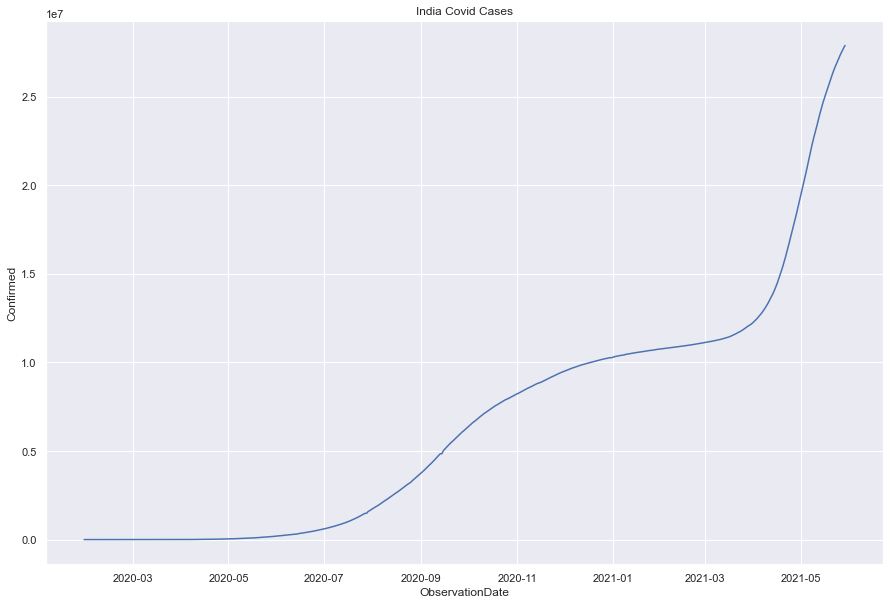

In [10]:
# plot India case trend

plt.figure(figsize=(15, 10))
sns.lineplot(x="ObservationDate", y="Confirmed",legend = 'full' , data=india_df)
plt.title('India Covid Cases')
plt.show()

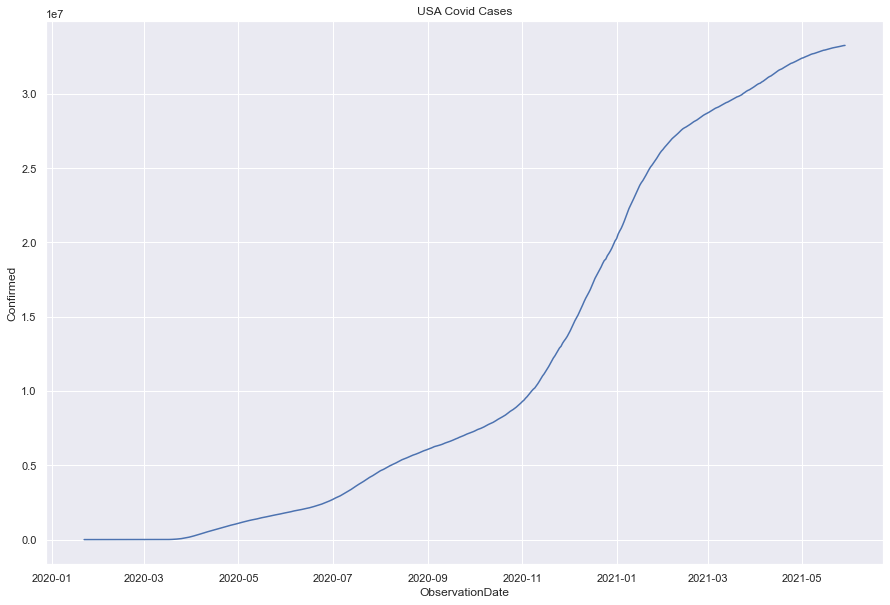

In [11]:
# plot USA case trend

plt.figure(figsize=(15, 10))
sns.lineplot(x="ObservationDate", y="Confirmed",legend = 'full' , data=usa_df)
plt.title('USA Covid Cases')
plt.show()

### Forecasting Models

#### Polynomial Regression

India

In [12]:
y = india_df.Confirmed.values
X = np.arange(len(y))
X = X.reshape(-1,1)

In [13]:
# use time series split for train/test sets and cross validation

tscv = TimeSeriesSplit(test_size=14)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [14]:
# create polynomial regression model with degree 5

poly_model = PolynomialFeatures(degree=5)
x_reg = poly_model.fit_transform(X_train)
poly_model.fit(x_reg,y_train)
lin_model = LinearRegression()
lin_model.fit(x_reg,y_train)
y_pred_train = lin_model.predict(poly_model.fit_transform(X_train))
y_pred_test = lin_model.predict(poly_model.fit_transform(X_test))

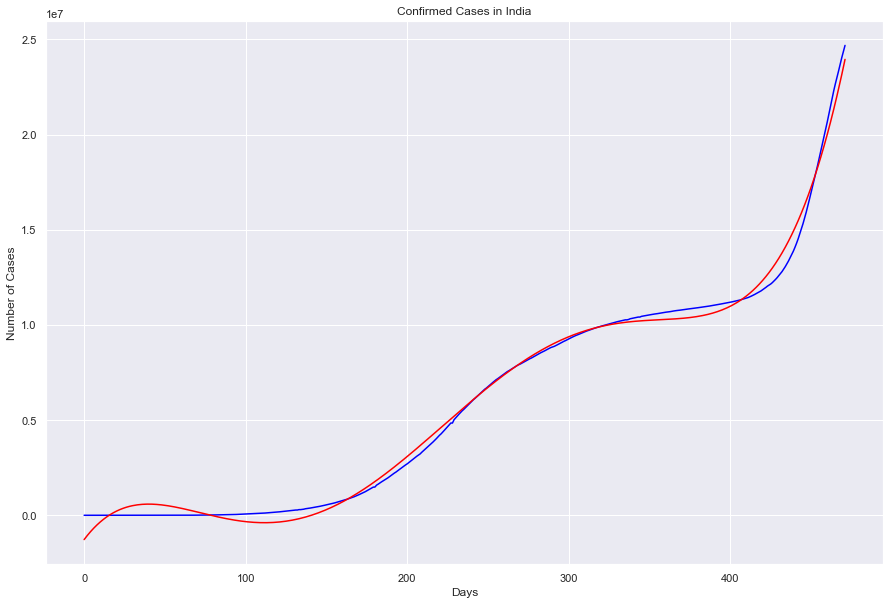

In [15]:
# plot model output vs actual cases

plt.figure(figsize=(15,10))
plt.plot(X_train,y_train,color="blue")
plt.plot(X_train,lin_model.predict(poly_model.fit_transform(X_train)),color="red")
plt.title("Confirmed Cases in India")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.show()

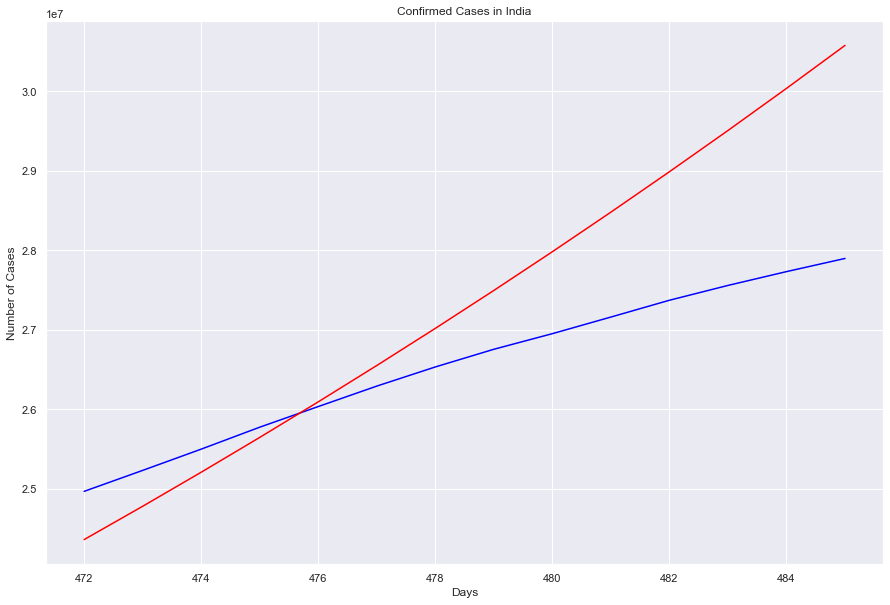

In [16]:
# plot test set predictions vs actual cases

plt.figure(figsize=(15,10))
plt.plot(X_test,y_test,color="blue")
plt.plot(X_test,lin_model.predict(poly_model.fit_transform(X_test)),color="red")
plt.title("Confirmed Cases in India")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.show()

In [17]:
# evaluate model

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
print('train r squared: ', train_r2)
print('test r squared: ', test_r2)
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)

train r squared:  0.9950796192462943
test r squared:  -0.9756192063598239
root mean squared error:  1288100.876967046
mean absolute error:  994211.4742721847
mean absolute percentage error:  3.6599524749212415


USA

In [18]:
# create polynomial regression model with degree 4

y = usa_df.Confirmed.values
X = np.arange(len(y))
X = X.reshape(-1,1)

tscv = TimeSeriesSplit(test_size=14)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
poly_model = PolynomialFeatures(degree=4)
x_reg = poly_model.fit_transform(X_train)
poly_model.fit(x_reg,y_train)
lin_model = LinearRegression()
lin_model.fit(x_reg,y_train)
y_pred_train = lin_model.predict(poly_model.fit_transform(X_train))
y_pred_test = lin_model.predict(poly_model.fit_transform(X_test))

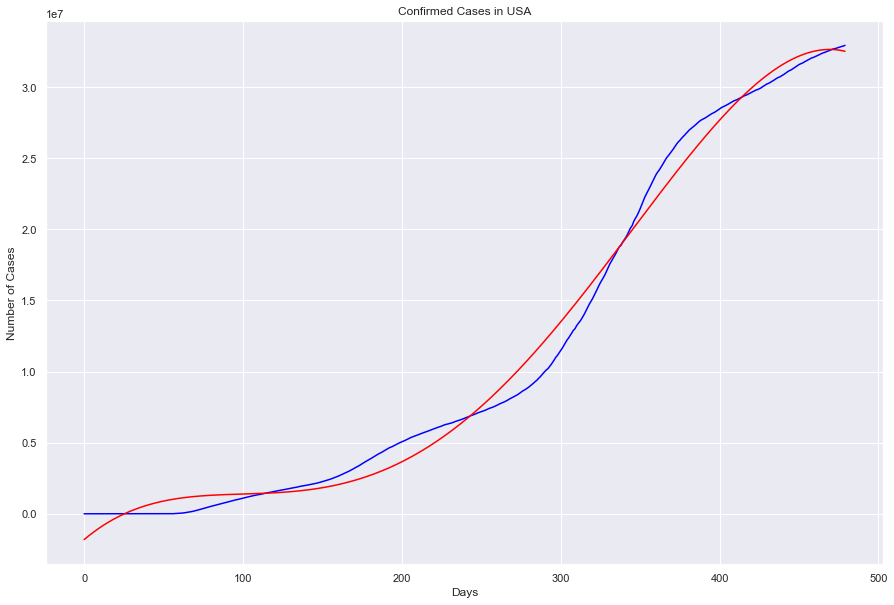

In [19]:
# plot model output vs actual cases

plt.figure(figsize=(15,10))
plt.plot(X_train,y_train,color="blue")
plt.plot(X_train,lin_model.predict(poly_model.fit_transform(X_train)),color="red")
plt.title("Confirmed Cases in USA")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.show()

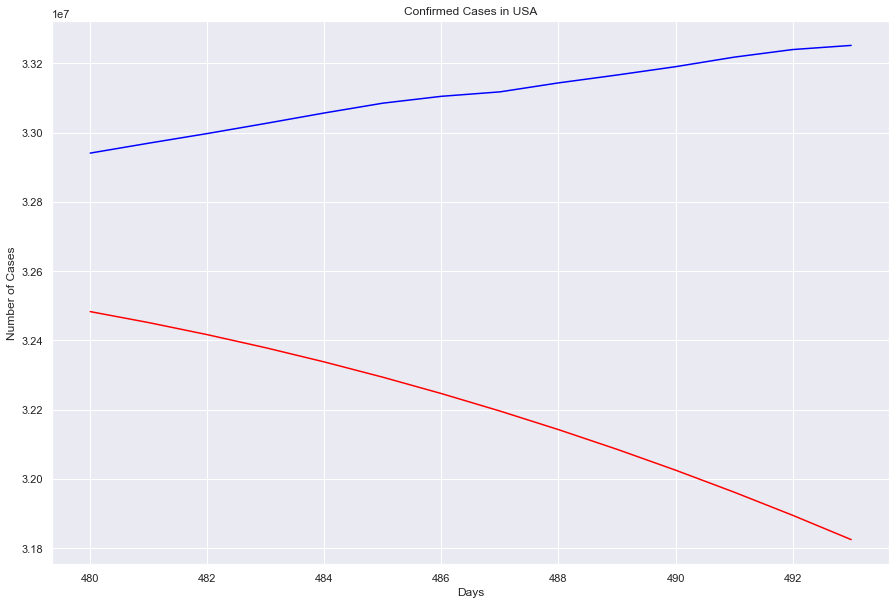

In [20]:
# plot test set predictions vs actual cases

plt.figure(figsize=(15,10))
plt.plot(X_test,y_test,color="blue")
plt.plot(X_test,lin_model.predict(poly_model.fit_transform(X_test)),color="red")
plt.title("Confirmed Cases in USA")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.show()

In [21]:
# evaluate model

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
print('train r squared: ', train_r2)
print('test r squared: ', test_r2)
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)

train r squared:  0.9920366155668521
test r squared:  -97.70028420561934
root mean squared error:  960867.9704904375
mean absolute error:  912509.7305138111
mean absolute percentage error:  2.7535629610381327


#### SARIMAX

India

In [22]:
# make index datetime for model input

india_df.index = pd.to_datetime(india_df.index)

In [23]:
india_df.head()

,Confirmed
ObservationDate,
2020-01-30,1
2020-01-31,1
2020-02-01,1
2020-02-02,2
2020-02-03,3


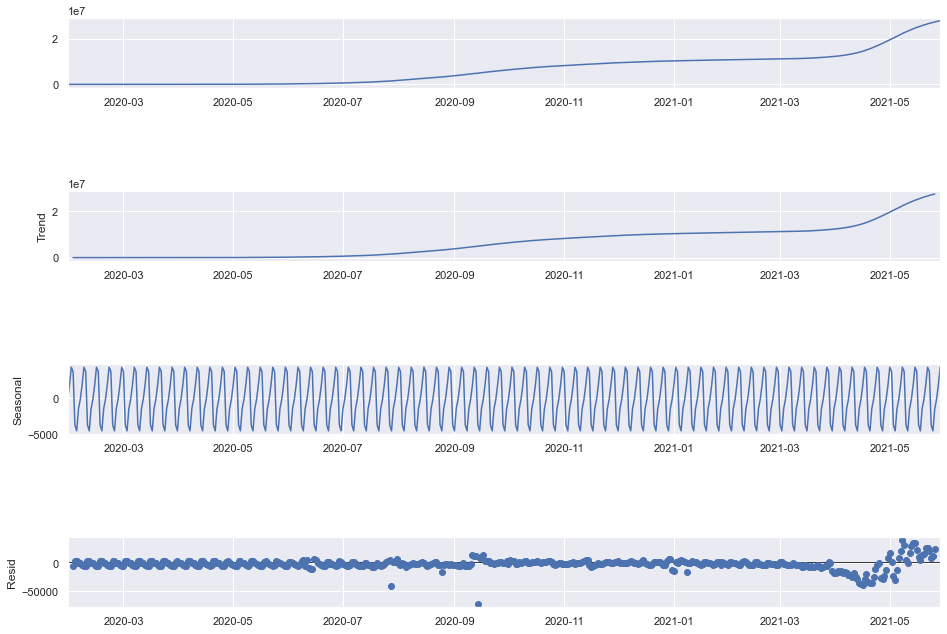

In [24]:
# check for trend and seasonality

decomposition = sm.tsa.seasonal_decompose(india_df, model='additive')
fig = decomposition.plot()
fig.set_size_inches(15, 10)

In [25]:
# test for stationarity using Dickey-Fuller test

# source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    fig = plt.figure(figsize=(15, 10))
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

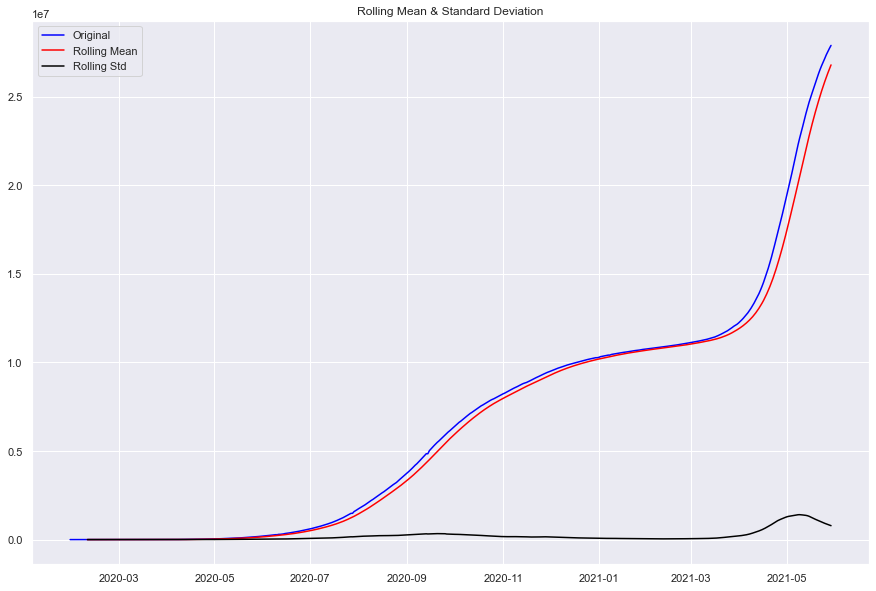

Results of Dickey-Fuller Test:
Test Statistic                   1.791630
p-value                          0.998332
#Lags Used                      16.000000
Number of Observations Used    469.000000
Critical Value (1%)             -3.444370
Critical Value (5%)             -2.867722
Critical Value (10%)            -2.570063
dtype: float64


In [26]:
test_stationarity(india_df)

In [27]:
# perform first order differencing

india_df_diff = india_df.diff(periods=1).dropna()

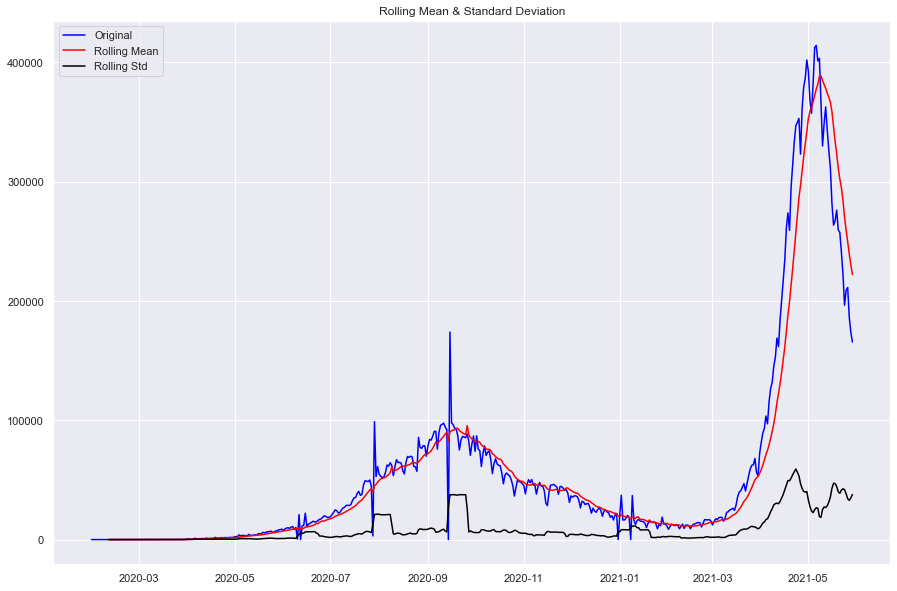

Results of Dickey-Fuller Test:
Test Statistic                  -3.789289
p-value                          0.003019
#Lags Used                      13.000000
Number of Observations Used    471.000000
Critical Value (1%)             -3.444310
Critical Value (5%)             -2.867696
Critical Value (10%)            -2.570049
dtype: float64


In [28]:
test_stationarity(india_df_diff)

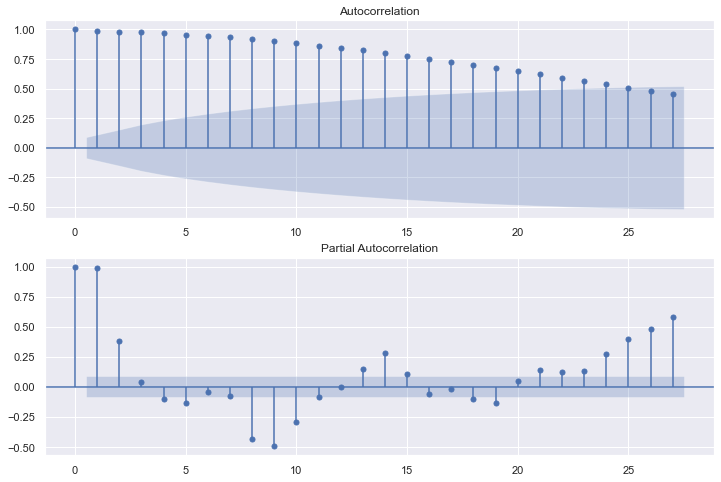

In [29]:
# check for autcorrelation and partial autocorrelation to determine model parameters

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(india_df_diff.Confirmed, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(india_df_diff.Confirmed, ax=ax2)

In [30]:
# create train and test sets

train_df = india_df[:-14]
test_df = india_df[-14:]
train = train_df.Confirmed
test = test_df.Confirmed

/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


root mean squared error:  49541.383678850616
mean absolute error:  40669.4075343702
mean absolute percentage error:  0.14999913365343318


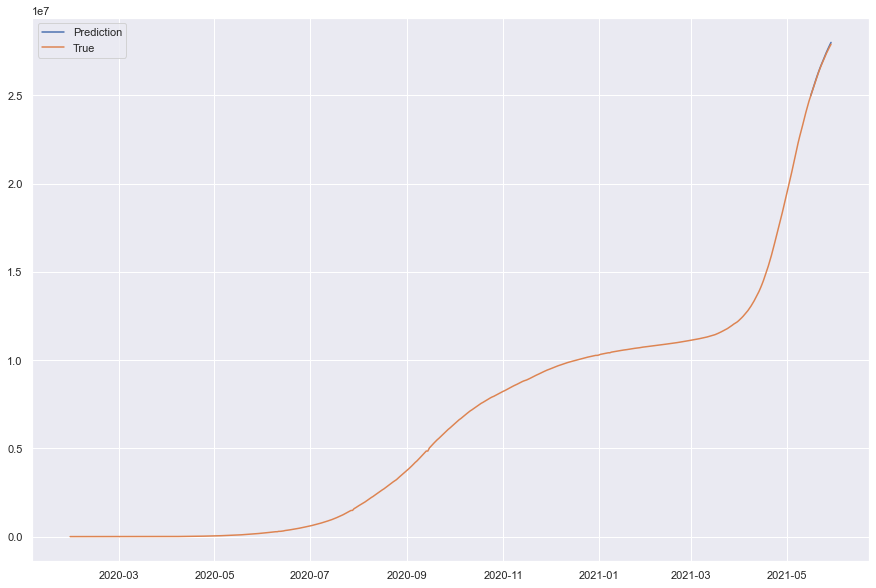

In [31]:
# build, fit, and evaluate model

fit_model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(2,1,24)).fit()
yhat = fit_model.forecast(len(test))
rmse = np.sqrt(mean_squared_error(test,yhat))
mae = mean_absolute_error(test,yhat)
mape = mean_absolute_percentage_error(test,yhat)
test_df['yhat'] = yhat
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)
plt.figure(figsize=(15,10))
plt.plot(test_df['yhat'], label = 'Prediction')
plt.plot(india_df.Confirmed, label = 'True')
plt.legend()
plt.show()

In [32]:
print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  472
Model:              SARIMAX(2, 1, 24)   Log Likelihood               -5005.818
Date:                Sun, 27 Jun 2021   AIC                          10065.636
Time:                        17:37:42   BIC                          10177.817
Sample:                    01-30-2020   HQIC                         10109.767
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3308      0.633      2.104      0.035       0.091       2.571
ar.L2         -0.3389      0.629     -0.539      0.590      -1.571       0.893
ma.L1         -1.1183      0.639     -1.751      0.0

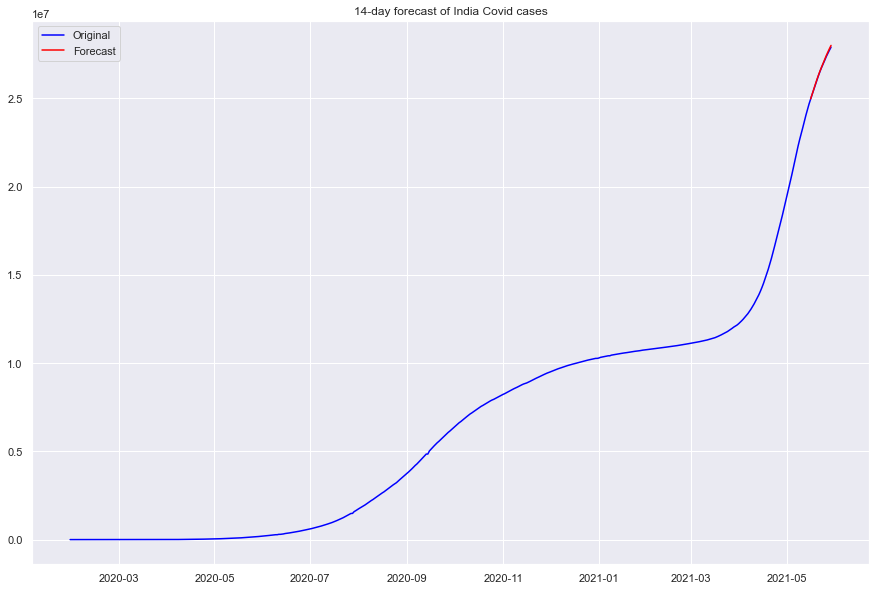

In [33]:
# plot forecast

forecast_days = fit_model.predict(start= '16-May-21',end = datetime.strptime("16-May-21", "%d-%b-%y")+timedelta(days=13) ,dynamic= True,)
fig = plt.figure(figsize=(15, 10))
orig = plt.plot(india_df['Confirmed'], color='blue',label='Original')
forecast = plt.plot(forecast_days, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('14-day forecast of India Covid cases')
plt.show()

In [34]:
# get 95% confidence intervals

conf = fit_model.get_forecast(14)
conf = conf.conf_int()
conf

,lower Confirmed,upper Confirmed
2021-05-16,2.494660e+07,2.499231e+07
2021-05-17,2.520360e+07,2.527545e+07
2021-05-18,2.546241e+07,2.556580e+07
2021-05-19,2.572437e+07,2.586354e+07
2021-05-20,2.597129e+07,2.615200e+07
2021-05-21,2.619952e+07,2.642907e+07
2021-05-22,2.641066e+07,2.669905e+07
2021-05-23,2.659701e+07,2.695876e+07
2021-05-24,2.676932e+07,2.721358e+07
2021-05-25,2.694359e+07,2.747755e+07


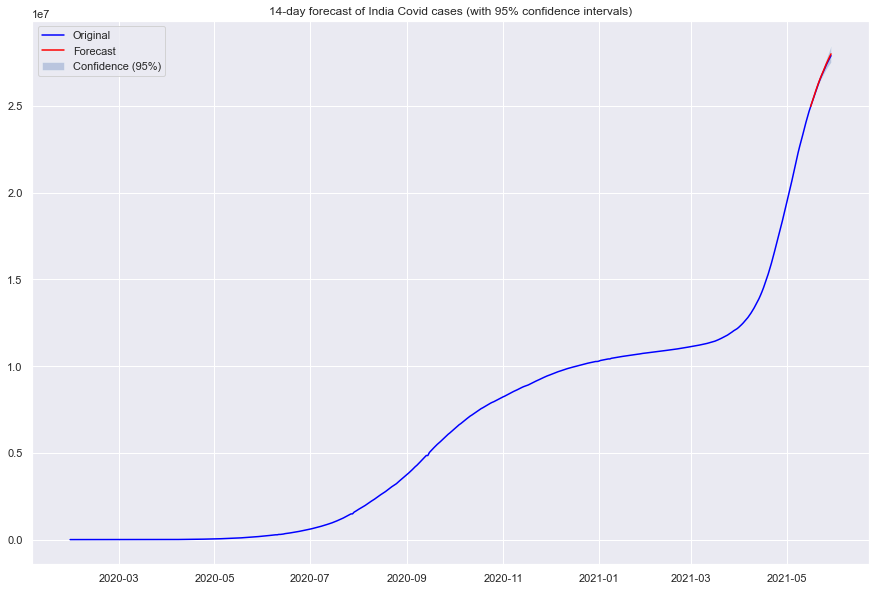

In [35]:
# plot forecast with confidence intervals

fig = plt.figure(figsize=(15, 10))
orig = plt.plot(india_df['Confirmed'], color='blue',label='Original')
forecast = plt.plot(forecast_days, color='red', label='Forecast')
confidence = plt.fill_between(conf.index, conf['upper Confirmed'], conf['lower Confirmed'],
                              alpha=0.3, label='Confidence (95%)')
plt.legend(loc='best')
plt.title('14-day forecast of India Covid cases (with 95% confidence intervals)')
plt.show()

USA

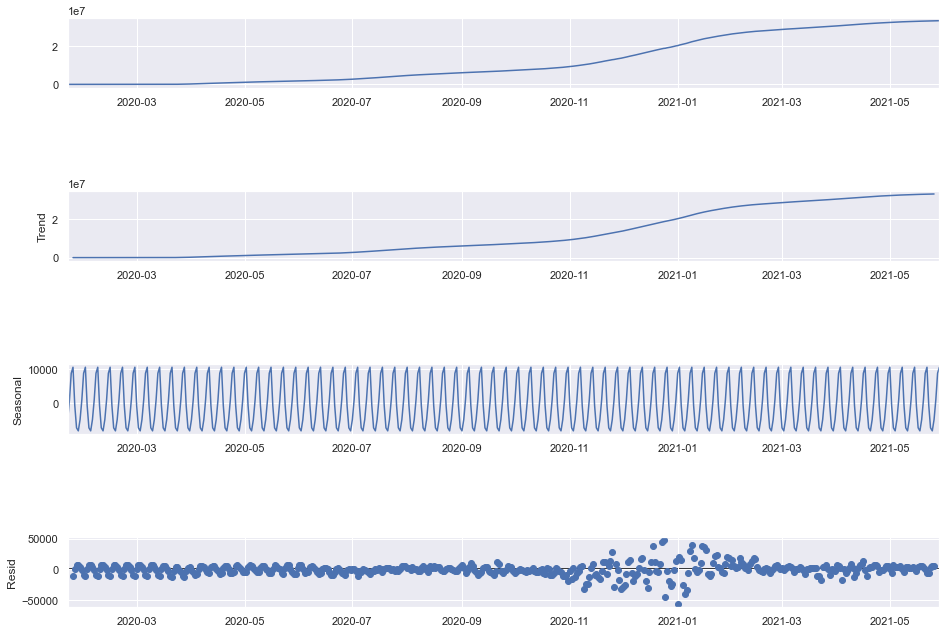

In [36]:
# check for trend and seasonality

usa_df.index = pd.to_datetime(usa_df.index)

decomposition = sm.tsa.seasonal_decompose(usa_df, model='additive')
fig = decomposition.plot()
fig.set_size_inches(15, 10)

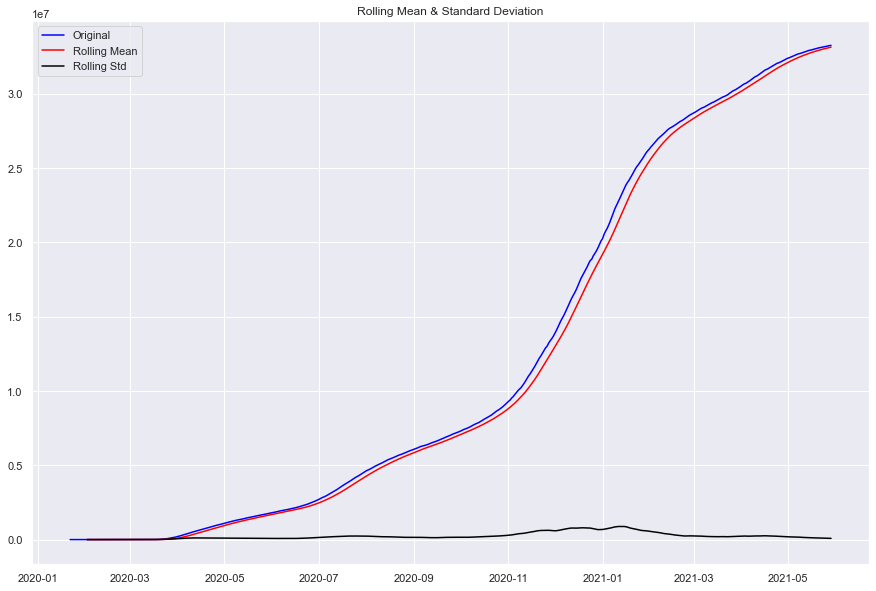

Results of Dickey-Fuller Test:
Test Statistic                  -1.064424
p-value                          0.729049
#Lags Used                      18.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


In [37]:
test_stationarity(usa_df)

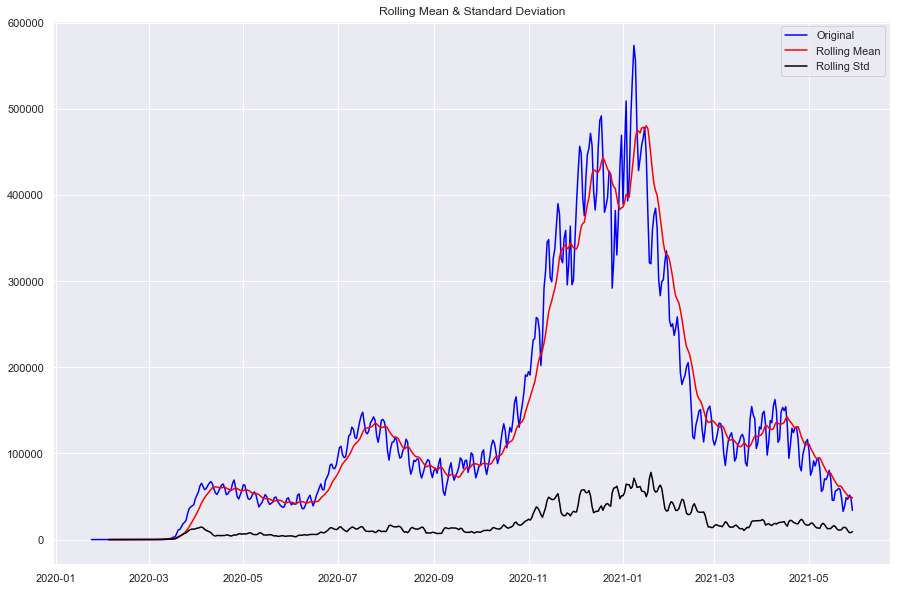

Results of Dickey-Fuller Test:
Test Statistic                  -1.613423
p-value                          0.476179
#Lags Used                      18.000000
Number of Observations Used    473.000000
Critical Value (1%)             -3.444251
Critical Value (5%)             -2.867670
Critical Value (10%)            -2.570035
dtype: float64


In [38]:
# perform second order differencing

usa_df_diff = usa_df.diff(periods=2).dropna()
test_stationarity(usa_df_diff)

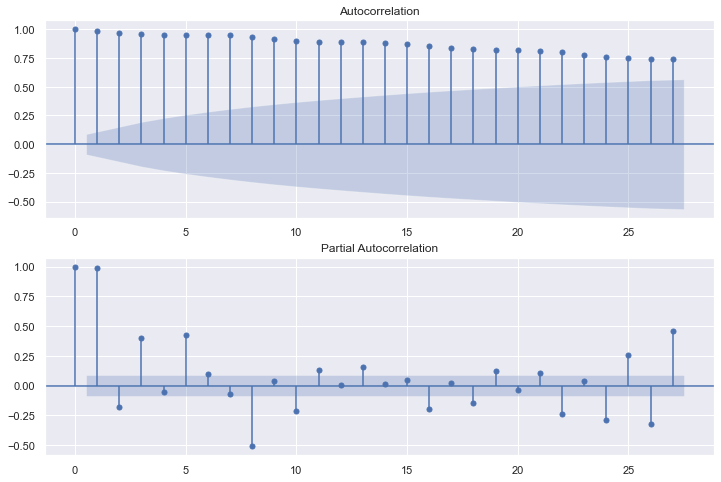

In [39]:
# check for autcorrelation and partial autocorrelation to determine model parameters

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(usa_df_diff.Confirmed, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(usa_df_diff.Confirmed, ax=ax2)

In [40]:
# create train and test sets

train_df = usa_df[:-14]
test_df = usa_df[-14:]
train = train_df.Confirmed
test = test_df.Confirmed

/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/richa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


root mean squared error:  27587.87698491351
mean absolute error:  24570.88456596993
mean absolute percentage error:  0.07410855186764014


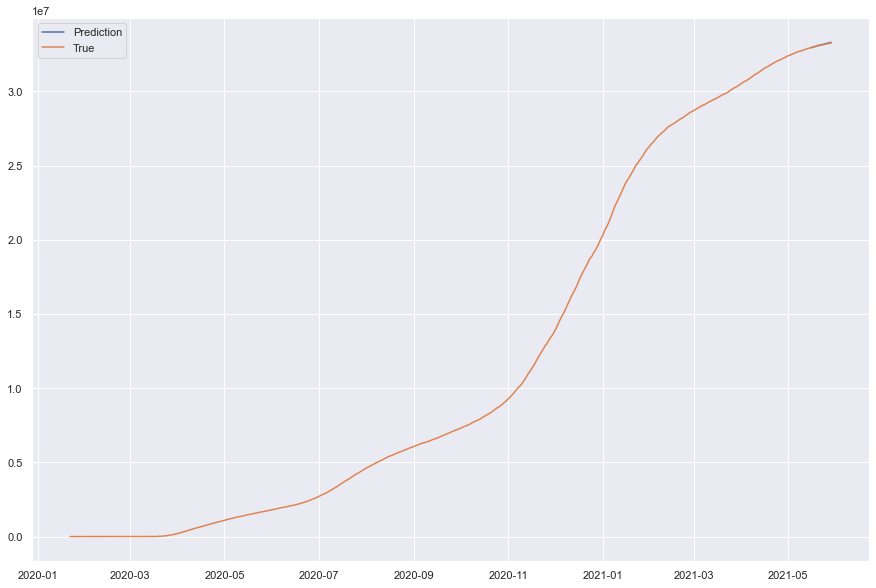

In [41]:
# build, fit, and evaluate model

fit_model = sm.tsa.statespace.SARIMAX(train, order=(2,2,24)).fit()
yhat = fit_model.forecast(len(test))
rmse = np.sqrt(mean_squared_error(test,yhat))
mae = mean_absolute_error(test,yhat)
mape = mean_absolute_percentage_error(test,yhat)
test_df['yhat'] = yhat
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)
plt.figure(figsize=(15,10))
plt.plot(test_df['yhat'], label = 'Prediction')
plt.plot(usa_df.Confirmed, label = 'True')
plt.legend()
plt.show()

In [42]:
print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  480
Model:              SARIMAX(2, 2, 24)   Log Likelihood               -5218.574
Date:                Sun, 27 Jun 2021   AIC                          10491.147
Time:                        17:37:53   BIC                          10603.727
Sample:                    01-22-2020   HQIC                         10535.408
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7983      0.541      1.475      0.140      -0.262       1.859
ar.L2         -0.0006      0.501     -0.001      0.999      -0.983       0.981
ma.L1         -1.4391      0.552     -2.607      0.0

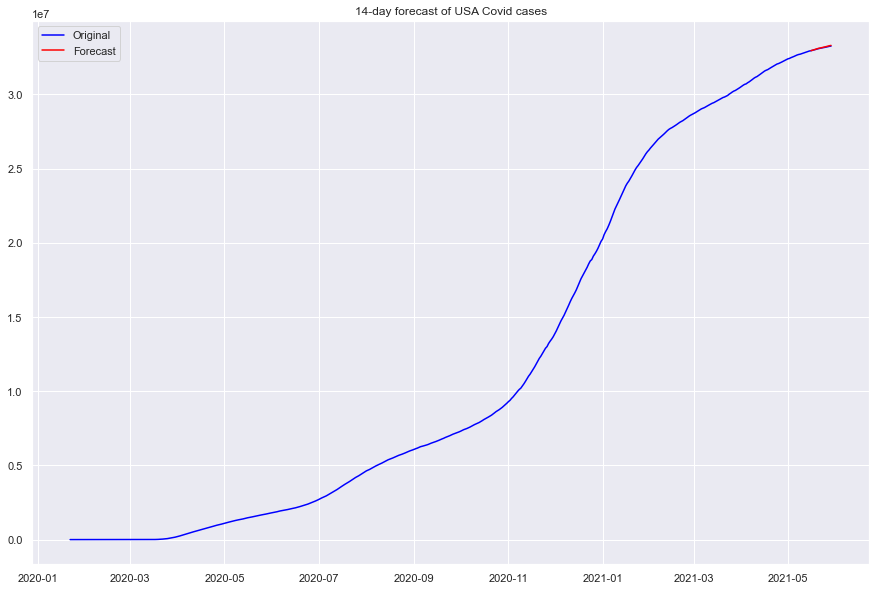

In [43]:
# plot forecast

forecast_days = fit_model.predict(start='16-May-21', end = datetime.strptime("16-May-21", "%d-%b-%y")+timedelta(days=13) ,dynamic= True)
fig = plt.figure(figsize=(15, 10))
orig = plt.plot(usa_df['Confirmed'], color='blue',label='Original')
forecast = plt.plot(forecast_days, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('14-day forecast of USA Covid cases')
plt.show()

In [44]:
# get 95% confidence intervals

conf = fit_model.get_forecast(14)
conf = conf.conf_int()
conf

,lower Confirmed,upper Confirmed
2021-05-16,3.291834e+07,3.297828e+07
2021-05-17,3.292513e+07,3.302628e+07
2021-05-18,3.293505e+07,3.308085e+07
2021-05-19,3.293946e+07,3.313460e+07
2021-05-20,3.295169e+07,3.319819e+07
2021-05-21,3.295394e+07,3.325580e+07
2021-05-22,3.294309e+07,3.330800e+07
2021-05-23,3.292700e+07,3.337358e+07
2021-05-24,3.290960e+07,3.344047e+07
2021-05-25,3.288980e+07,3.350698e+07


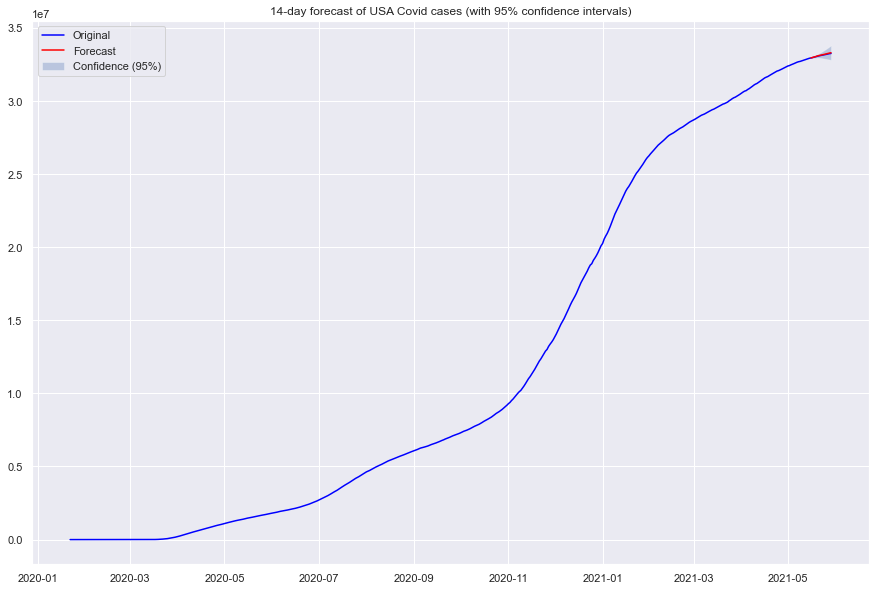

In [45]:
# plot forecast with 95% confidence intervals

fig = plt.figure(figsize=(15, 10))
orig = plt.plot(usa_df['Confirmed'], color='blue',label='Original')
forecast = plt.plot(forecast_days, color='red', label='Forecast')
confidence = plt.fill_between(conf.index, conf['upper Confirmed'], conf['lower Confirmed'],
                              alpha=0.3, label='Confidence (95%)')

plt.legend(loc='best')
plt.title('14-day forecast of USA Covid cases (with 95% confidence intervals)')
plt.show()

#### Prophet

India

In [46]:
# create appropriate columns for model input

india_df_prophet = india_df.copy()
india_df_prophet.reset_index(inplace=True)
india_df_prophet = india_df_prophet[['ObservationDate','Confirmed']].rename(columns = {'ObservationDate':'ds', 'Confirmed':'y'})
india_df_prophet.head()

,ds,y
0,2020-01-30,1
1,2020-01-31,1
2,2020-02-01,1
3,2020-02-02,2
4,2020-02-03,3


In [47]:
# create train and test sets

train_df = india_df_prophet[india_df_prophet['ds'] < '2021-05-16']
test_df = india_df_prophet[india_df_prophet['ds'] >= '2021-05-16']

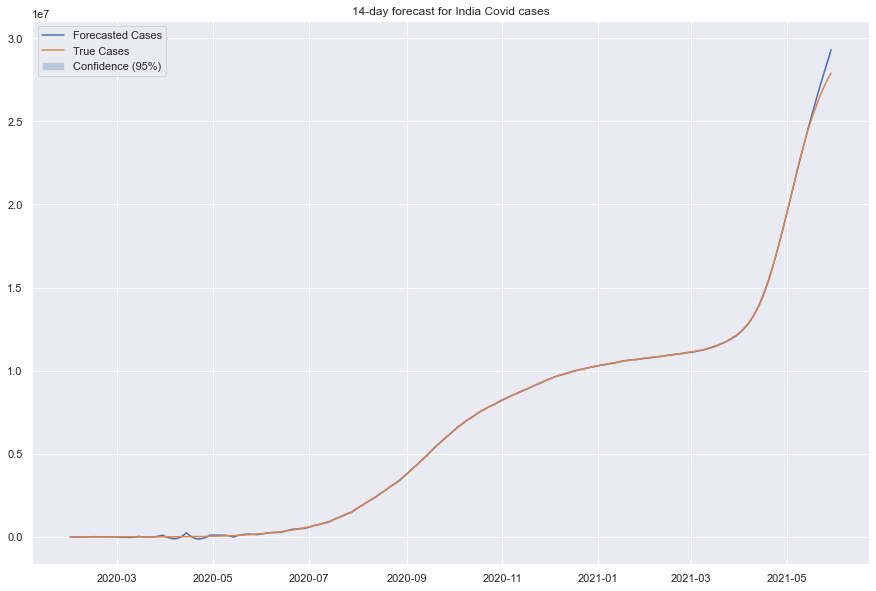

In [48]:
# build model and plot forecast with 95& confidence intervals

forecast_length = 14
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df)
future = model.make_future_dataframe(periods=forecast_length)
forecast = model.predict(future)

to_plot = forecast[forecast.ds > '2020-01-30'].merge(india_df_prophet, how='left')

plt.figure(figsize = (15,10))
plt.plot(to_plot['ds'], to_plot['yhat'], label='Forecasted Cases')
plt.plot(to_plot['ds'], to_plot['y'], label='True Cases')
plt.fill_between(to_plot['ds'], to_plot['yhat_upper'], to_plot['yhat_lower'],
                 alpha=0.3, label='Confidence (95%)')
plt.title('14-day forecast for India Covid cases')
plt.legend()
plt.show()

In [49]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-30,4.792846e+05,-47113.438316,35233.092968,4.792846e+05,4.792846e+05,-4.841099e+05,-4.841099e+05,-4.841099e+05,1.923049e+06,...,928.818591,928.818591,928.818591,-2.408088e+06,-2.408088e+06,-2.408088e+06,0.0,0.0,0.0,-4825.233268
1,2020-01-31,6.228113e+05,-47180.072023,37173.123482,6.228113e+05,6.228113e+05,-6.252607e+05,-6.252607e+05,-6.252607e+05,1.923049e+06,...,3002.487510,3002.487510,3002.487510,-2.551312e+06,-2.551312e+06,-2.551312e+06,0.0,0.0,0.0,-2449.321199
2,2020-02-01,7.663380e+05,-43566.099480,38580.260927,7.663380e+05,7.663380e+05,-7.670623e+05,-7.670623e+05,-7.670623e+05,1.923049e+06,...,4481.587939,4481.587939,4481.587939,-2.694593e+06,-2.694593e+06,-2.694593e+06,0.0,0.0,0.0,-724.313093
3,2020-02-02,9.098647e+05,-36557.745534,41615.327572,9.098647e+05,9.098647e+05,-9.102258e+05,-9.102258e+05,-9.102258e+05,1.923049e+06,...,4573.138041,4573.138041,4573.138041,-2.837848e+06,-2.837848e+06,-2.837848e+06,0.0,0.0,0.0,-361.065473
4,2020-02-03,1.053391e+06,-48159.009171,33415.402229,1.053391e+06,1.053391e+06,-1.062191e+06,-1.062191e+06,-1.062191e+06,1.923049e+06,...,-4227.007713,-4227.007713,-4227.007713,-2.981013e+06,-2.981013e+06,-2.981013e+06,0.0,0.0,0.0,-8799.289195


In [50]:
# evaluate model

rmse = np.sqrt(mean_squared_error(test_df.y,forecast['yhat'][-14:]))
mae = mean_absolute_error(test_df.y,forecast['yhat'][-14:])
mape = mean_absolute_percentage_error(test_df.y,forecast['yhat'][-14:])
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)

root mean squared error:  797161.5389517153
mean absolute error:  698063.3102227971
mean absolute percentage error:  2.5831392235638733


In [51]:
# try cross validation to prevent overfitting

df_cv = cross_validation(model, initial='366 days', period='20 days', horizon = '100 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-04 00:00:00 and 2021-02-04 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-02-05,1.081825e+07,1.081075e+07,1.082647e+07,10814304,2021-02-04
1,2021-02-06,1.083234e+07,1.082487e+07,1.084028e+07,10826363,2021-02-04
2,2021-02-07,1.084408e+07,1.083656e+07,1.085194e+07,10838194,2021-02-04
3,2021-02-08,1.085074e+07,1.084344e+07,1.085877e+07,10847304,2021-02-04
4,2021-02-09,1.086269e+07,1.085490e+07,1.087026e+07,10858371,2021-02-04


In [53]:
# evaluate model

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,5.536348e+07,7440.663872,6940.450488,0.000638,0.000548,0.000638,0.6
1,11 days,5.941270e+07,7707.963163,7294.686943,0.000670,0.000619,0.000670,0.6
2,12 days,6.115704e+07,7820.296770,7426.113760,0.000682,0.000676,0.000681,0.6
3,13 days,6.444484e+07,8027.754425,7659.207886,0.000702,0.000718,0.000702,0.6
4,14 days,6.845544e+07,8273.780062,8036.191607,0.000736,0.000718,0.000736,0.6


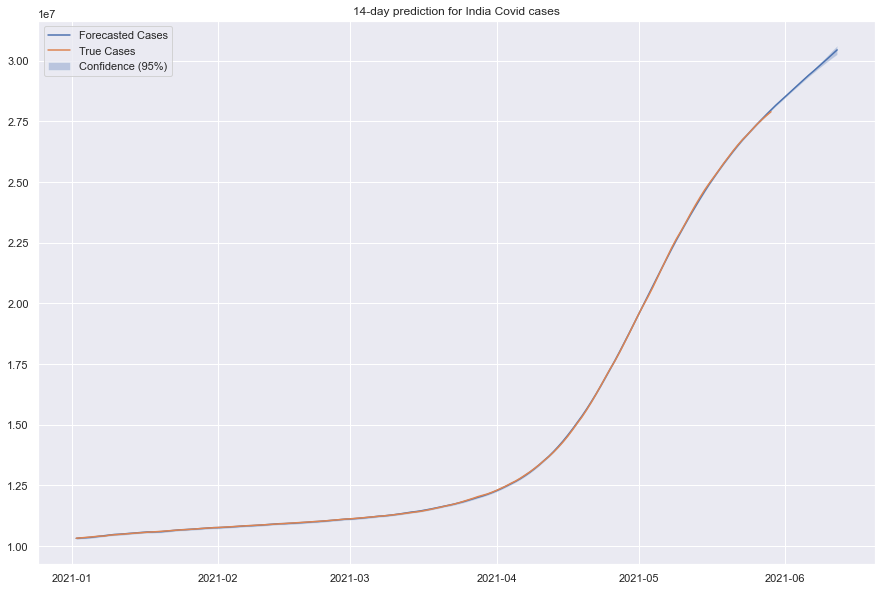

In [54]:
# predict future cases for the next 2 weeks with 95& confidence intervals

forecast_length = 14
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(india_df_prophet)
future = model.make_future_dataframe(periods=forecast_length)
forecast = model.predict(future)

to_plot = forecast[forecast.ds > '2021-01-01'].merge(india_df_prophet, how='left')

plt.figure(figsize = (15,10))
plt.plot(to_plot['ds'], to_plot['yhat'], label='Forecasted Cases')
plt.plot(to_plot['ds'], to_plot['y'], label='True Cases')
plt.fill_between(to_plot['ds'], to_plot['yhat_upper'], to_plot['yhat_lower'],
                 alpha=0.3, label='Confidence (95%)')
plt.title('14-day prediction for India Covid cases')
plt.legend()
plt.show()

In [55]:
# create prediction dataframe

prophet_df_india = to_plot[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y']].copy()

y_diff = prophet_df_india.y.diff()
yhat_diff = prophet_df_india.yhat.diff()
yhat_lower_diff = prophet_df_india.yhat_lower.diff()
yhat_upper_diff = prophet_df_india.yhat_upper.diff()

prophet_df_india['y_diff'] = y_diff
prophet_df_india['yhat_diff'] = yhat_diff
prophet_df_india['yhat_lower_diff'] = yhat_lower_diff
prophet_df_india['yhat_upper_diff'] = yhat_upper_diff
prophet_df_india.iloc[:-15]['yhat'] = np.nan
prophet_df_india.iloc[:-15]['yhat_lower'] = np.nan
prophet_df_india.iloc[:-15]['yhat_upper'] = np.nan
prophet_df_india.head()

,ds,yhat_lower,yhat_upper,yhat,y,y_diff,yhat_diff,yhat_lower_diff,yhat_upper_diff
0,2021-01-02,NaN,NaN,NaN,10323965.0,NaN,NaN,NaN,NaN
1,2021-01-03,NaN,NaN,NaN,10340469.0,16504.0,19440.350508,22161.713148,16389.856223
2,2021-01-04,NaN,NaN,NaN,10356844.0,16375.0,8346.963850,7872.715604,12166.562279
3,2021-01-05,NaN,NaN,NaN,10374932.0,18088.0,14539.285931,12967.930263,14256.550250
4,2021-01-06,NaN,NaN,NaN,10395278.0,20346.0,24233.852820,23147.076326,19793.370063


In [56]:
# save to csv file

prophet_df_india.to_csv('prophet_df_india.csv', encoding='utf-8', index=False)

USA

In [57]:
# create appropriate columns for model input

usa_df_prophet = usa_df.copy()
usa_df_prophet.reset_index(inplace=True)
usa_df_prophet = usa_df_prophet[['ObservationDate','Confirmed']].rename(columns = {'ObservationDate':'ds', 'Confirmed':'y'})
usa_df_prophet.head()

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,5


In [58]:
# create train and test sets

train_df = usa_df_prophet[usa_df_prophet['ds'] < '2021-05-16']
test_df = usa_df_prophet[usa_df_prophet['ds'] >= '2021-05-16']

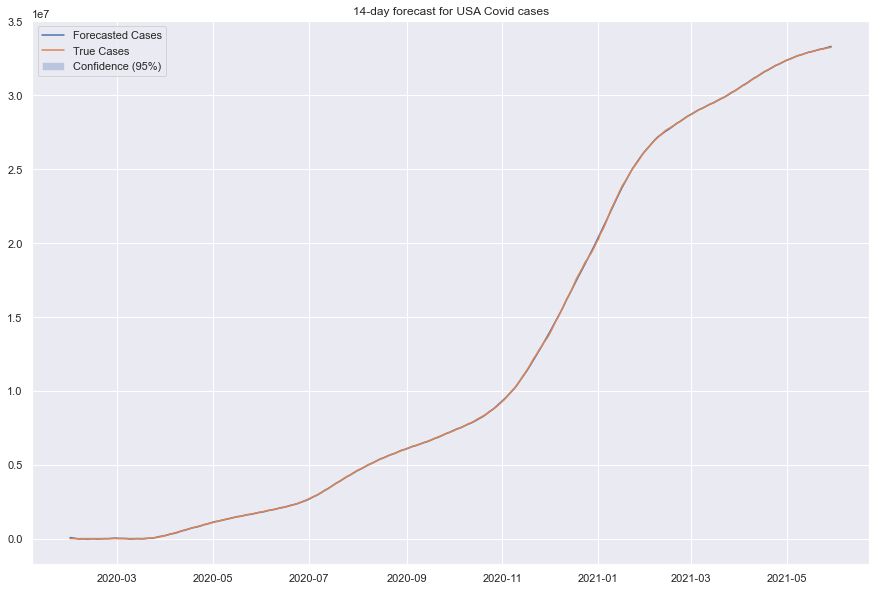

In [59]:
# build model and plot forecast with 95& confidence intervals

forecast_length = 14
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df)
future = model.make_future_dataframe(periods=forecast_length)
forecast = model.predict(future)

to_plot = forecast[forecast.ds > '2020-01-30'].merge(usa_df_prophet, how='left')

plt.figure(figsize = (15,10))
plt.plot(to_plot['ds'], to_plot['yhat'], label='Forecasted Cases')
plt.plot(to_plot['ds'], to_plot['y'], label='True Cases')
plt.fill_between(to_plot['ds'], to_plot['yhat_upper'], to_plot['yhat_lower'],
                 alpha=0.3, label='Confidence (95%)')
plt.title('14-day forecast for USA Covid cases')
plt.legend()
plt.show()

In [60]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-649630.09084,-157771.182339,-85049.799137,-649630.09084,-649630.09084,529566.376171,529566.376171,529566.376171,-2.601033e+06,...,-3414.459208,-3414.459208,-3414.459208,3.134014e+06,3.134014e+06,3.134014e+06,0.0,0.0,0.0,-120063.714669
1,2020-01-23,-668161.40785,-111222.850331,-35837.734129,-668161.40785,-668161.40785,595780.000065,595780.000065,595780.000065,-2.601033e+06,...,2035.330631,2035.330631,2035.330631,3.194778e+06,3.194778e+06,3.194778e+06,0.0,0.0,0.0,-72381.407785
2,2020-01-24,-686692.72486,-67265.547253,9519.405165,-686692.72486,-686692.72486,657613.141554,657613.141554,657613.141554,-2.601033e+06,...,9125.823914,9125.823914,9125.823914,3.249521e+06,3.249521e+06,3.249521e+06,0.0,0.0,0.0,-29079.583306
3,2020-01-25,-705224.04187,-32349.503351,40769.538112,-705224.04187,-705224.04187,707759.670574,707759.670574,707759.670574,-2.601033e+06,...,10526.301367,10526.301367,10526.301367,3.298267e+06,3.298267e+06,3.298267e+06,0.0,0.0,0.0,2535.628704
4,2020-01-26,-723755.35888,-22432.508132,53505.735797,-723755.35888,-723755.35888,739198.168251,739198.168251,739198.168251,-2.601033e+06,...,-878.409731,-878.409731,-878.409731,3.341110e+06,3.341110e+06,3.341110e+06,0.0,0.0,0.0,15442.809370


In [61]:
# evaluate model

rmse = np.sqrt(mean_squared_error(test_df.y,forecast['yhat'][-14:]))
mae = mean_absolute_error(test_df.y,forecast['yhat'][-14:])
mape = mean_absolute_percentage_error(test_df.y,forecast['yhat'][-14:])
print('root mean squared error: ', rmse)
print('mean absolute error: ', mae)
print('mean absolute percentage error: ', mape*100)

root mean squared error:  26424.55057408027
mean absolute error:  19532.75037463834
mean absolute percentage error:  0.05886004968172284


In [62]:
# try cross validation to prevent overfitting

df_cv = cross_validation(model, initial='366 days', period='20 days', horizon = '100 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-04 00:00:00 and 2021-02-04 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-02-05,2.682748e+07,2.679319e+07,2.686468e+07,26877601,2021-02-04
1,2021-02-06,2.694099e+07,2.690536e+07,2.697733e+07,26981588,2021-02-04
2,2021-02-07,2.704220e+07,2.700299e+07,2.707653e+07,27071236,2021-02-04
3,2021-02-08,2.714428e+07,2.710825e+07,2.718331e+07,27161551,2021-02-04
4,2021-02-09,2.725361e+07,2.721507e+07,2.729439e+07,27257183,2021-02-04


In [64]:
# evaluate model

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,3.002754e+09,54797.390519,43460.161459,0.001585,0.001289,0.001584,0.5
1,11 days,6.006125e+09,77499.193613,56488.705884,0.002049,0.001289,0.002045,0.5
2,12 days,1.149330e+10,107206.824818,76202.747860,0.002752,0.001396,0.002745,0.5
3,13 days,2.008510e+10,141721.920902,102754.212436,0.003701,0.002293,0.003688,0.4
4,14 days,3.253696e+10,180380.056758,136356.512216,0.004901,0.003654,0.004880,0.3


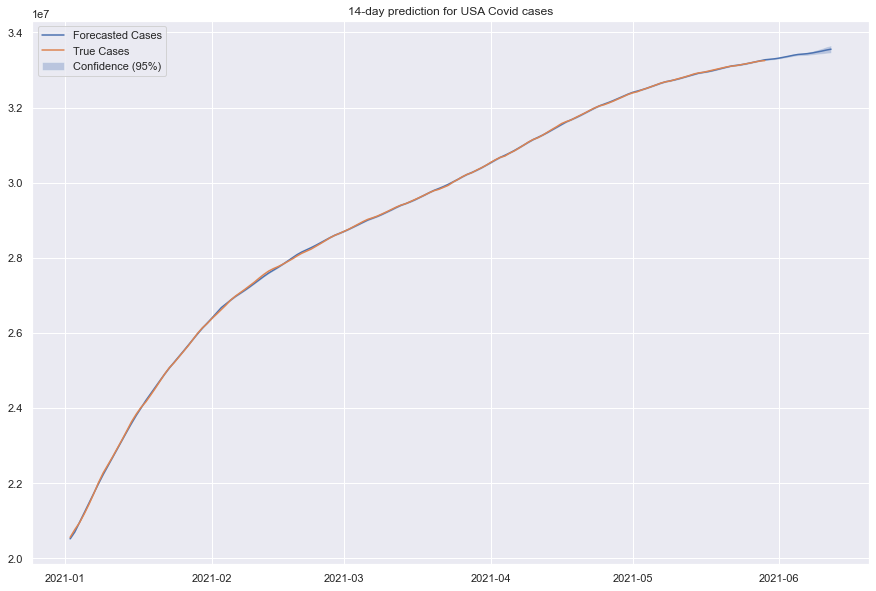

In [65]:
# predict future cases for the next 2 weeks with 95& confidence intervals

forecast_length = 14
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(usa_df_prophet)
future = model.make_future_dataframe(periods=forecast_length)
forecast = model.predict(future)

to_plot = forecast[forecast.ds > '2021-01-01'].merge(usa_df_prophet, how='left')

plt.figure(figsize = (15,10))
plt.plot(to_plot['ds'], to_plot['yhat'], label='Forecasted Cases')
plt.plot(to_plot['ds'], to_plot['y'], label='True Cases')
plt.fill_between(to_plot['ds'], to_plot['yhat_upper'], to_plot['yhat_lower'],
                 alpha=0.3, label='Confidence (95%)')
plt.title('14-day prediction for USA Covid cases')
plt.legend()
plt.show()

In [66]:
# create prediction dataframe

prophet_df_usa = to_plot[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y']].copy()

y_diff = prophet_df_usa.y.diff()
yhat_diff = prophet_df_usa.yhat.diff()
yhat_lower_diff = prophet_df_usa.yhat_lower.diff()
yhat_upper_diff = prophet_df_usa.yhat_upper.diff()

prophet_df_usa['y_diff'] = y_diff
prophet_df_usa['yhat_diff'] = yhat_diff
prophet_df_usa['yhat_lower_diff'] = yhat_lower_diff
prophet_df_usa['yhat_upper_diff'] = yhat_upper_diff
prophet_df_usa.iloc[:-15]['yhat'] = np.nan
prophet_df_usa.iloc[:-15]['yhat_lower'] = np.nan
prophet_df_usa.iloc[:-15]['yhat_upper'] = np.nan
prophet_df_usa.head()

,ds,yhat_lower,yhat_upper,yhat,y,y_diff,yhat_diff,yhat_lower_diff,yhat_upper_diff
0,2021-01-02,NaN,NaN,NaN,20553301.0,NaN,NaN,NaN,NaN
1,2021-01-03,NaN,NaN,NaN,20762047.0,208746.0,185889.220697,187047.493435,185825.217810
2,2021-01-04,NaN,NaN,NaN,20946329.0,184282.0,254252.230737,251805.899747,254602.792732
3,2021-01-05,NaN,NaN,NaN,21181440.0,235111.0,257299.003038,259751.284837,258534.399676
4,2021-01-06,NaN,NaN,NaN,21436884.0,255444.0,259249.748946,258671.355844,258705.632200


In [67]:
# save to csv file

prophet_df_usa.to_csv('prophet_df_usa.csv', encoding='utf-8', index=False)

#### Model evaluation results using MAPE

Polynomial Regression<br>
India: 3.660<br>
USA: 2.754<br>

SARIMAX<br>
India: 0.150<br>
USA: 0.074<br>

Prophet<br>
India: 2.583<br>
USA: 0.059<br>

Overall, the SARIMAX and Prophet models have performed well for both India and the USA. Further tweaks to model parameters would likely also improve accuracy.<br>
As expected, polynomial regression was not as accurate for time series forecasting as it is prone to overfitting and does not extrapolate well past the training set. Traditional time series forecasting models like ARIMA and SARIMAX are ideal for this type of univariate dataset, where lags should be taken into account.<br>
However, accurately tuning parameters for these models require some in-depth knowledge of how these models work. Prophet uses a slightly different technique, but is much more intuitive and does not require major tuning of parameters, so is therefore a great choice for most time series forecasting data with trends or seasonality.